In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statistics import mean, stdev
import sys
import os
if "../" not in sys.path:
  sys.path.append("../") 
os.chdir("..") 
from envs.data_handler import DataHandler, perform_ttest

# function for plotting
def plot_data(data_table, type):
    lists = data_table.groupby(['Optimal_Affected_Component_Uid', 'Optimal_Failure'])[type].apply(list).values
    fig = plt.figure(figsize=(50, 5))
    for l in lists:
        plt.hist(l, 50, alpha=0.5)
    plt.show()

dh = DataHandler(environment='Saturating')
dh.data.head()

Saturating.csv
Saturating.csv
Saturating.csv
Saturating.csv
Saturating.csv
Saturating.csv
Saturating.csv
Saturating.csv
Saturating.csv
Saturating.csv
Saturating.csv
Saturating.csv
Saturating.csv
Saturating.csv
Saturating.csv
Saturating.csv


,Optimal_Affected_Component,Optimal_Affected_Component_Uid,Optimal_Failure,raw,cube,sqt,log10,ln,log2
0,Query Service,_SEwwu-cdEeet0YmmfbMwkw,CF1,638.460292,5.558599,13.105330,2.234896,5.146038,7.424164
1,Last Second Sales Item Filter,_SExXrOcdEeet0YmmfbMwkw,CF2,96.674251,4.920383,10.914362,2.075997,4.780159,6.896312
2,Buy Now Item Filter,_SEx_ROcdEeet0YmmfbMwkw,CF5,111.194731,4.920383,10.914362,2.075997,4.780159,6.896312
3,Availability Item Filter,_SEymNucdEeet0YmmfbMwkw,CF5,36.912446,4.594071,9.846831,1.986593,4.574299,6.599319
4,Past Sales Item Filter,_SEx-n-cdEeet0YmmfbMwkw,CF3,96.960084,3.559606,6.715880,1.654206,3.808950,5.495153


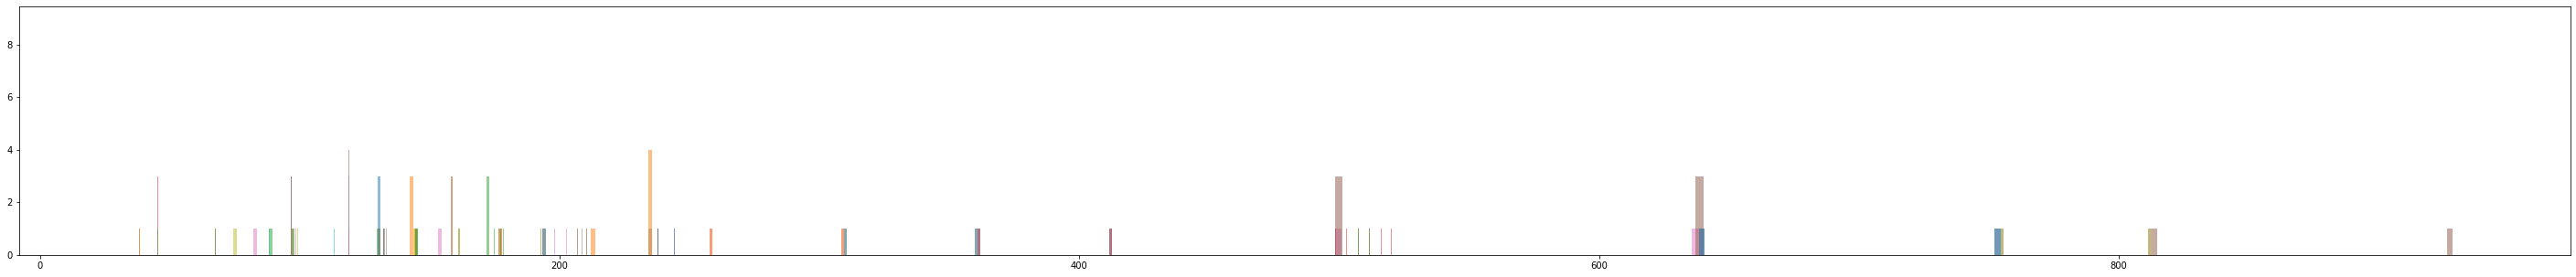

In [2]:
plot_data(dh.data, 'raw')

# Data Shift

## Step 1: Calculate the Standard Deviation and the mean of each <component, failure> combinations

In [3]:
mean_values = dh.data.groupby(['Optimal_Affected_Component_Uid', 'Optimal_Failure']).mean().reset_index()
stdev_values = dh.data.groupby(['Optimal_Affected_Component_Uid', 'Optimal_Failure']).std().reset_index().fillna(0)

## Step 2: Sort data by mean values 

In [4]:
mean_values = mean_values.sort_values(by=['raw'], ascending=True)

## Step 3: Iterate over data and shift it

In [5]:
data_new = dh.data.copy()

previous = None
for _, name in mean_values.iterrows():
    if previous is not None:
        pre_std = stdev_values.loc[(stdev_values['Optimal_Affected_Component_Uid'] == previous[0]) & (stdev_values['Optimal_Failure'] == previous[1])]['raw'].tolist()[0]
        cur_std = stdev_values.loc[(stdev_values['Optimal_Affected_Component_Uid'] == name[0]) & (stdev_values['Optimal_Failure'] == name[1])]['raw'].tolist()[0]
        data_new.loc[(data_new['Optimal_Affected_Component_Uid'] == name[0]) & (data_new['Optimal_Failure'] == name[1]), 'raw'] += cur_std + pre_std
    previous = name
    
data_new.head()

,Optimal_Affected_Component,Optimal_Affected_Component_Uid,Optimal_Failure,raw,cube,sqt,log10,ln,log2
0,Query Service,_SEwwu-cdEeet0YmmfbMwkw,CF1,638.460292,5.558599,13.105330,2.234896,5.146038,7.424164
1,Last Second Sales Item Filter,_SExXrOcdEeet0YmmfbMwkw,CF2,96.674251,4.920383,10.914362,2.075997,4.780159,6.896312
2,Buy Now Item Filter,_SEx_ROcdEeet0YmmfbMwkw,CF5,111.194731,4.920383,10.914362,2.075997,4.780159,6.896312
3,Availability Item Filter,_SEymNucdEeet0YmmfbMwkw,CF5,37.155318,4.594071,9.846831,1.986593,4.574299,6.599319
4,Past Sales Item Filter,_SEx-n-cdEeet0YmmfbMwkw,CF3,96.960084,3.559606,6.715880,1.654206,3.808950,5.495153


## Step 4: Analyse

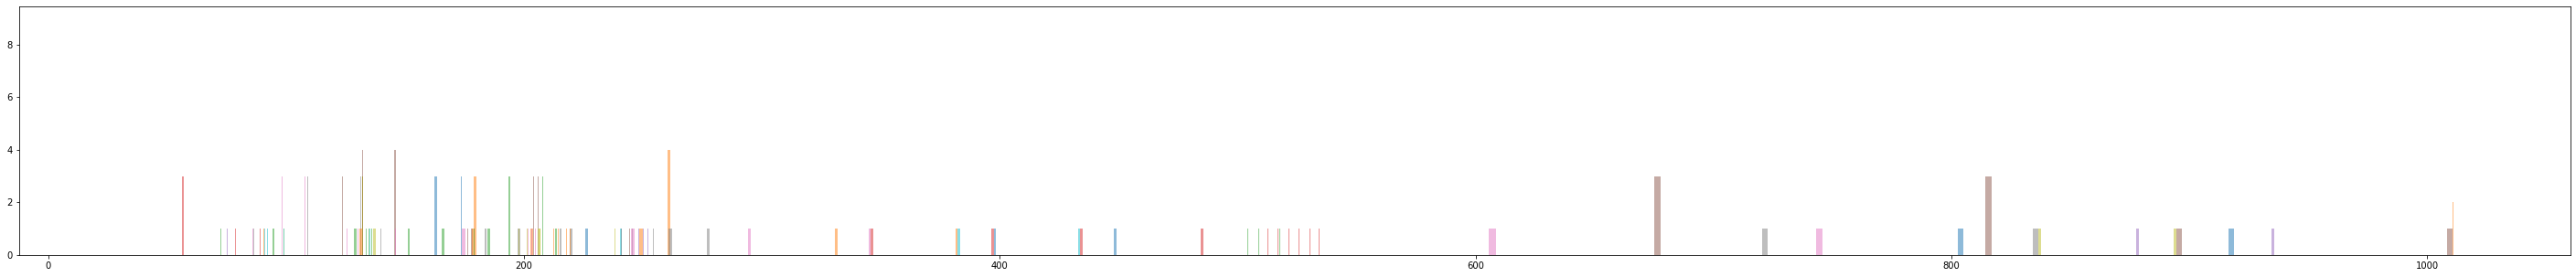

In [6]:
plot_data(data_new, 'raw')

## Step 5: Perform T-Test

In [13]:
result = perform_ttest(mean_values, data_new, 'raw')
print(len(result[result['pvalue']<0.025]), 'of the ', len(result.index) ,' <component, failure> combination pairs are statistical significant')

49 of the  890  <component, failure> combination pairs are statistical significant


# Experiment

First transform data and then shift it.

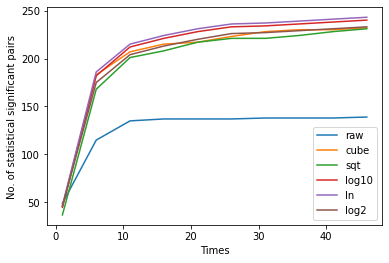

In [12]:
# <component, failure> = x + (prestd + curstd) * times
types = ['raw', 'cube', 'sqt', 'log10', 'ln', 'log2']
x_ticks = range(1,50, 5)

for t in types:
    results = []
    for i in x_ticks:
        (means, shifted_data) = dh.shift_data(t, times=i)
        ttest = perform_ttest(means, shifted_data, t)
        r = len(ttest[ttest['pvalue']<0.025])
        results.append(r)
    plt.plot(x_ticks, results, label=t)

plt.xlabel("Times")
plt.ylabel("No. of statistical significant pairs")
plt.legend()
plt.show()